In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from Preprocessingfunctions import convertclock,OutlierDetection
import statsmodels.api as spearman
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from matplotlib import cm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

shotlogs=pd.read_csv('shot_logs.csv')

In [2]:
print(shotlogs.head())

    GAME_ID                   MATCHUP LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            1   
1  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            2   
2  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            3   
3  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            4   
4  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            5   

   PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  ...  SHOT_DIST  PTS_TYPE  \
0       1       1:09        10.8         2  ...        7.7         2   
1       1       0:14         3.4         0  ...       28.2         3   
2       1       0:00         NaN         3  ...       10.1         2   
3       2      11:47        10.3         2  ...       17.2         2   
4       2      10:34        10.9         2  ...        3.7         2   

   SHOT_RESULT   CLOSEST_DEFENDER CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  \
0     

In [3]:
shotlogs.describe()
print(f"Dataset Shape: {shotlogs.shape[0]} rows, {shotlogs.shape[1]} cols")

Dataset Shape: 128069 rows, 21 cols


In [4]:
shotlogs.isnull().sum().sort_values(ascending=False)

SHOT_CLOCK                    5567
GAME_ID                          0
SHOT_DIST                        0
player_name                      0
PTS                              0
FGM                              0
CLOSE_DEF_DIST                   0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSEST_DEFENDER                 0
SHOT_RESULT                      0
PTS_TYPE                         0
TOUCH_TIME                       0
MATCHUP                          0
DRIBBLES                         0
GAME_CLOCK                       0
PERIOD                           0
SHOT_NUMBER                      0
FINAL_MARGIN                     0
W                                0
LOCATION                         0
player_id                        0
dtype: int64

For shots that occur at the end of quarters, place the time left on clock in the missing shot clock entries

In [5]:
shotlogs['GAME_CLOCK']=shotlogs['GAME_CLOCK'].apply(convertclock)
shotlogs['GAME_CLOCK']=pd.to_numeric(shotlogs['GAME_CLOCK'], errors='coerce')
shotlogs['SHOT_CLOCK']=shotlogs['SHOT_CLOCK'].fillna(shotlogs['GAME_CLOCK'])
shotlogs['SHOT_CLOCK']=pd.to_numeric(shotlogs['SHOT_CLOCK'], errors='coerce')

Convert binary text columns ('LOCATION','W','SHOT_RESULT) to 0s and 1s

In [6]:
shotlogs['LOCATION']=np.where(shotlogs['LOCATION']=='A',0,1)
shotlogs['W']=np.where(shotlogs['W']=='W',1,0)
shotlogs['SHOT_RESULT']=np.where(shotlogs['SHOT_RESULT']=='made',1,0)

In [7]:
print(shotlogs.head())

    GAME_ID                   MATCHUP  LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            1   
1  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            2   
2  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            3   
3  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            4   
4  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            5   

   PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  ...  SHOT_DIST  PTS_TYPE  \
0       1          69        10.8         2  ...        7.7         2   
1       1          14         3.4         0  ...       28.2         3   
2       1           0         0.0         3  ...       10.1         2   
3       2         707        10.3         2  ...       17.2         2   
4       2         634        10.9         2  ...        3.7         2   

   SHOT_RESULT   CLOSEST_DEFENDER CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DI

Outlier Detection

Outlier handling for Master DataFrame, based upon boxplots found in Univariate_EDA; SHOT_DIST, TOUCH_TIME and CLOSE_DEF_DIST have the greatest number of outliers.

In [8]:
OutlierDetection(shotlogs[['SHOT_DIST','TOUCH_TIME','CLOSE_DEF_DIST']])

/Users/michaelgriffin/TensorFlowProject/TensorFlow-First-Project/Functions/Preprocessingfunctions.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df=clean_df[mask]


,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST
0,7.7,1.9,1.3
1,28.2,0.8,6.1
2,10.1,2.7,0.9
3,17.2,1.9,3.4
4,3.7,2.7,1.1
...,...,...,...
128064,8.7,6.2,0.8
128065,0.6,5.2,0.6
128066,16.9,4.2,4.2
128067,18.3,4.5,3.0


In [9]:
X=shotlogs[['FINAL_MARGIN','SHOT_NUMBER','PERIOD','GAME_CLOCK','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST','W','SHOT_RESULT','LOCATION']]

Based upon VIF scores and the Correlation Matrix found in Bivariate_EDA, Dimensionality Reduction will be necessary for 'TOUCH_TIME' and 'DRIBBLES', and 'PTS_TYPE' and 'SHOT_DIST'; VIF scores over 7 represent correlation that will causes issues.

In [10]:
reducedone=shotlogs[['PERIOD','TOUCH_TIME','PTS_TYPE','DRIBBLES']].copy(deep=True)
scalar=StandardScaler()
pca=PCA(n_components=2)
scaleddf=scalar.fit_transform(reducedone)
pca.fit(scaleddf)
pca_final=pca.transform(scaleddf)
pca_final=pd.DataFrame(pca_final, columns=['PC1','PC2'])
pca_final.head()

,PC1,PC2
0,-0.130434,-1.419324
1,-1.319353,-0.259190
2,0.246508,-1.386860
3,-0.078877,-0.682778
4,0.101306,-0.669317


<Axes: >

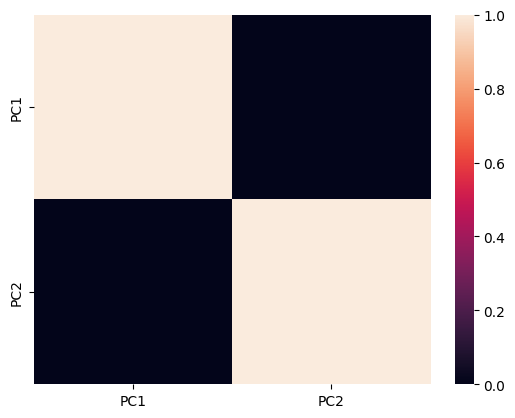

In [11]:
sns.heatmap(pca_final.corr())

In [12]:
final_shotlog=pd.concat([shotlogs,pca_final], axis=1)
final_shotlog=final_shotlog.drop(['PERIOD','TOUCH_TIME','DRIBBLES','PTS_TYPE'],axis=1)


Feature Engineering

Matchup splits into DateTime, then arena in which the game took place and then the tema for which the player played

In [13]:
final_shotlog[['Date','Matchup']]=final_shotlog['MATCHUP'].str.split('-', expand=True)

In [14]:
final_shotlog[['Away Team','Home Team']]=final_shotlog['Matchup'].str.split('@', expand=True)

In [15]:
print(final_shotlog.head())

    GAME_ID                   MATCHUP  LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            1   
1  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            2   
2  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            3   
3  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            4   
4  21400899  MAR 04, 2015 - CHA @ BKN         0  1            24            5   

   GAME_CLOCK  SHOT_CLOCK  SHOT_DIST  SHOT_RESULT  ... FGM  PTS  \
0          69        10.8        7.7            1  ...   1    2   
1          14         3.4       28.2            0  ...   0    0   
2           0         0.0       10.1            0  ...   0    0   
3         707        10.3       17.2            0  ...   0    0   
4         634        10.9        3.7            0  ...   0    0   

     player_name  player_id       PC1       PC2           Date     Matchup  \
0  brian roberts     203148 -0.1

In [16]:
final_shotlog=final_shotlog.drop(['MATCHUP'],axis=1)

Convert 'Date' to datetime object

In [17]:
final_shotlog['Date']=pd.to_datetime(final_shotlog['Date'], format='%b %d, %Y ')


Create Feature 'Player Team', which identifies the team to which the shooting player belongs

In [18]:
final_shotlog['Player_Team']=final_shotlog.apply(lambda row: row['Away Team'] if ['LOCATION'] == 'A' else row['Home Team'], axis=1)  

Convert

In [19]:
print(final_shotlog.head())

    GAME_ID  LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  GAME_CLOCK  SHOT_CLOCK  \
0  21400899         0  1            24            1          69        10.8   
1  21400899         0  1            24            2          14         3.4   
2  21400899         0  1            24            3           0         0.0   
3  21400899         0  1            24            4         707        10.3   
4  21400899         0  1            24            5         634        10.9   

   SHOT_DIST  SHOT_RESULT   CLOSEST_DEFENDER  ...  PTS    player_name  \
0        7.7            1     Anderson, Alan  ...    2  brian roberts   
1       28.2            0  Bogdanovic, Bojan  ...    0  brian roberts   
2       10.1            0  Bogdanovic, Bojan  ...    0  brian roberts   
3       17.2            0      Brown, Markel  ...    0  brian roberts   
4        3.7            0    Young, Thaddeus  ...    0  brian roberts   

   player_id       PC1       PC2       Date     Matchup  Away Team Home Team  \
0     

Scatterplot measuring chuck frequency: the shot distance increases as the game and shot clocks wind down, indicating a correlation between game circumstances and low-percentage shots.

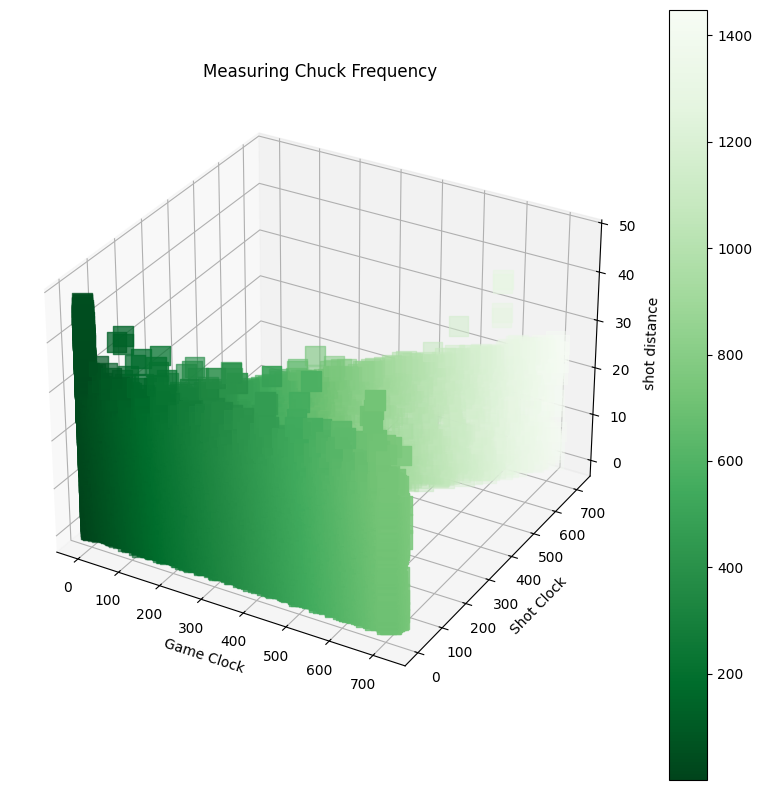

In [26]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
colo=[final_shotlog['GAME_CLOCK'] + final_shotlog['SHOT_CLOCK'] + final_shotlog['SHOT_DIST']]
color_map.set_array(colo)
img=ax.scatter(final_shotlog['GAME_CLOCK'],final_shotlog['SHOT_CLOCK'],final_shotlog['SHOT_DIST'],c=colo,cmap=cm.Greens_r, marker='s',s=200)
plt.colorbar(img,ax=ax)
plt.title("Measuring Chuck Frequency")
plt.xlabel('Game Clock')
plt.ylabel('Shot Clock')
ax.set_zlabel('shot distance')
plt.show()

Scatterplot measuring how open a given shooter is on made and missed shots

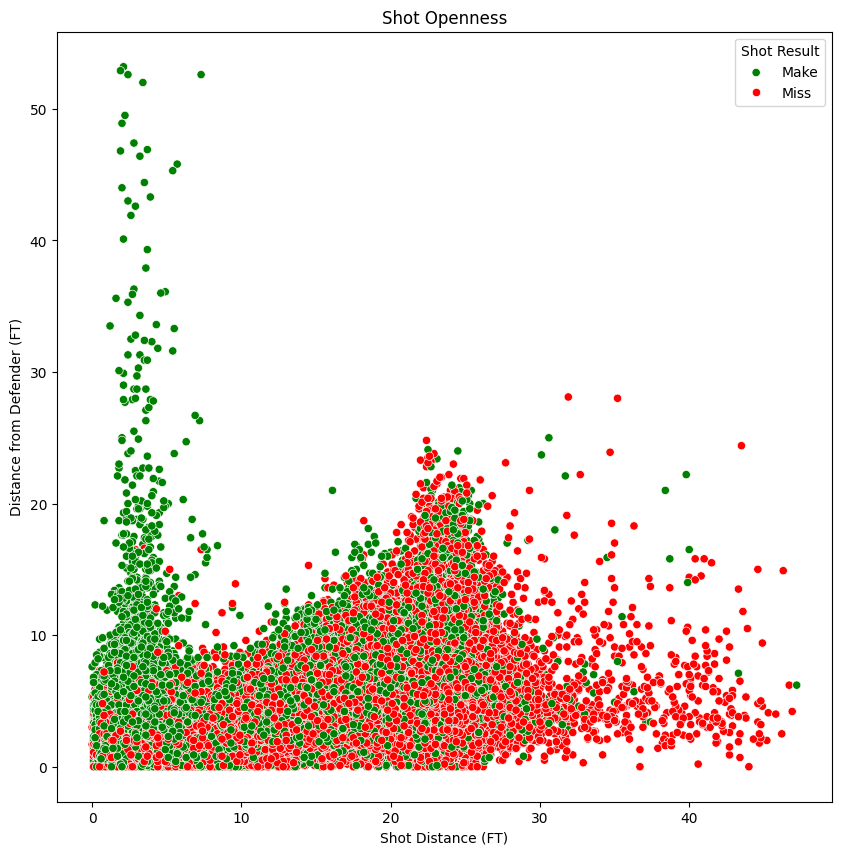

In [40]:
plt.figure(figsize=(10, 10))
# colors=final_shotlog["SHOT_RESULT"].map({1: 'green', 0:'red'})
sns.scatterplot(x=final_shotlog['SHOT_DIST'], y=final_shotlog['CLOSE_DEF_DIST'], hue=final_shotlog['SHOT_RESULT'], palette={1:'green', 0:'red'})
plt.legend(title='Shot Result',labels=['Make','Miss'],loc='upper right')
plt.title('Shot Openness')
plt.xlabel('Shot Distance (FT)')
plt.ylabel('Distance from Defender (FT)')
plt.show()

Calculate player's field goal percentage

In [48]:
final_shotlog['Player Field goal Percentage']=final_shotlog.groupby(['player_id'])['SHOT_RESULT'].transform('mean')


Calculate each defender's field goal percentage against

In [51]:
final_shotlog['Player Field goal Percentage against']=final_shotlog.groupby(['CLOSEST_DEFENDER_PLAYER_ID'])['SHOT_RESULT'].transform('mean')

In [ ]:
print(final_shotlog.head())